## Imports üì¶

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics

In [2]:
from matplotlib import pyplot as plt
import math
import seaborn as sns
import statistics

In [3]:
warnings.filterwarnings('ignore')

## Load Data üíø

In [4]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [5]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [6]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [9]:
pip install laserembeddings

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
!/usr/bin/python3 -m laserembeddings download-models


‚úÖ   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
‚úÖ   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
‚úÖ   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

‚ú® You're all set!


In [11]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [12]:
en_text_array.shape

(280, 1024)

In [13]:
en_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [14]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [15]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [16]:
es_emoji_array.shape

(280, 300)

##  Testing to see how many unique emojis in each comment (Don't run this part) üß™

In [17]:
# def emoji_embedding(df):
#     emoji_list_list = df['emoji list'].to_list()

#     # Initialize a list to store emoji embeddings
#     emoji_embedding = []
#     emoji_count = []
#     emoji_list_l = []

#     for emoji_list in emoji_list_list:
#         emoji_l = []
#         emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
#         count = 0
#         for emoji in emoji_list:
#             try:
#                 emoji_list_embedding.append(emoji_model[emoji])
#                 emoji_l.append(emoji)
#                 count+=1
                
#             except KeyError:
#                 pass
#         emoji_list_l.append(emoji_l)
#         emoji_count.append(count)

#         if len(emoji_list_embedding) != 0:
#             emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
#         emoji_embedding.append(emoji_list_embedding)

#     return emoji_count, emoji_embedding, emoji_list_l

In [18]:
# en_emoji_count, en_emoji_embedding, es_emoji = emoji_embedding(en_df)
# es_emoji_count, es_emoji_embedding, en_emoji = emoji_embedding(es_df)

In [19]:
# list1 = []
# for i in es_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list1.append(unique_list)
# list1 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts = [len(inner_list) for inner_list in list1]

# zero_count = 0

# for item in counts:
#     if item == 0:
#         zero_count += 1
# zero_count

In [20]:
# list2 = []
# for i in en_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list2.append(unique_list)
# list2 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts2 = [len(inner_list) for inner_list in list2]

# zero_count2 = 0

# for item in counts2:
#     if item == 0:
#         zero_count2 += 1
# zero_count2

## Concatenate the text embeddings and emoji embeddings 

In [21]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [22]:
en_embeddings.shape

(280, 1324)

In [23]:
en_emoji_array.shape

(280, 300)

## Embedding Distributions üìä

In [113]:
def make_dist_df(arr):
    df = pd.DataFrame(arr)
    df['average'], df['min'], df['max']  = 0, 0, 0
    for idx, row in df.iterrows():
        df.at[idx, 'average'] = statistics.mean(row)
        df.at[idx, 'min'] = min(row)
        df.at[idx, 'max'] = max(row)
    return df

def df_embeddings(en_text_array, es_text_array, en_emoji_array, es_emoji_array):
    en_text_df = make_dist_df(en_text_array)
    en_text_df['type'] = 'en_text'
    es_text_df = make_dist_df(es_text_array)
    es_text_df['type'] = 'es_text'
    en_emoji_df = make_dist_df(en_emoji_array)
    en_emoji_df['type'] = 'en_emoji'
    es_emoji_df = make_dist_df(es_emoji_array)
    es_emoji_df['type'] = 'es_emoji'

    all_df = pd.concat([en_text_df[['min','max','average','type']],
                        es_text_df[['min','max','average','type']],
                        en_emoji_df[['min','max','average','type']],
                        es_emoji_df[['min','max','average','type']]])
    return all_df

(-0.15, 0.48)

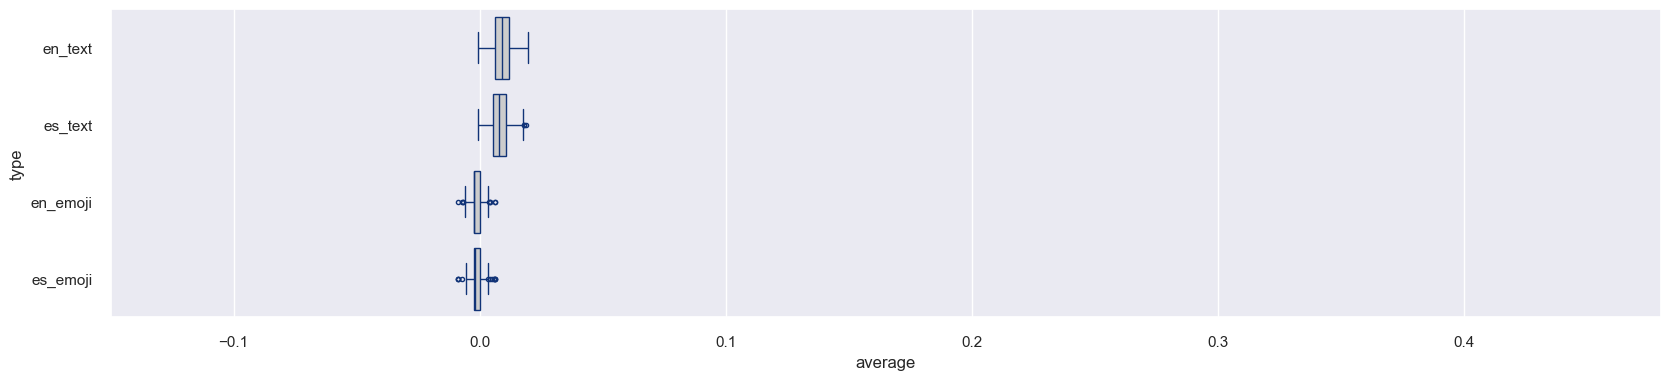

In [136]:
dist_df = df_embeddings(en_text_array, es_text_array, en_emoji_array, es_emoji_array)
sns.set(rc={'figure.figsize':(20,4)})

fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='average', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

(-0.15, 0.48)

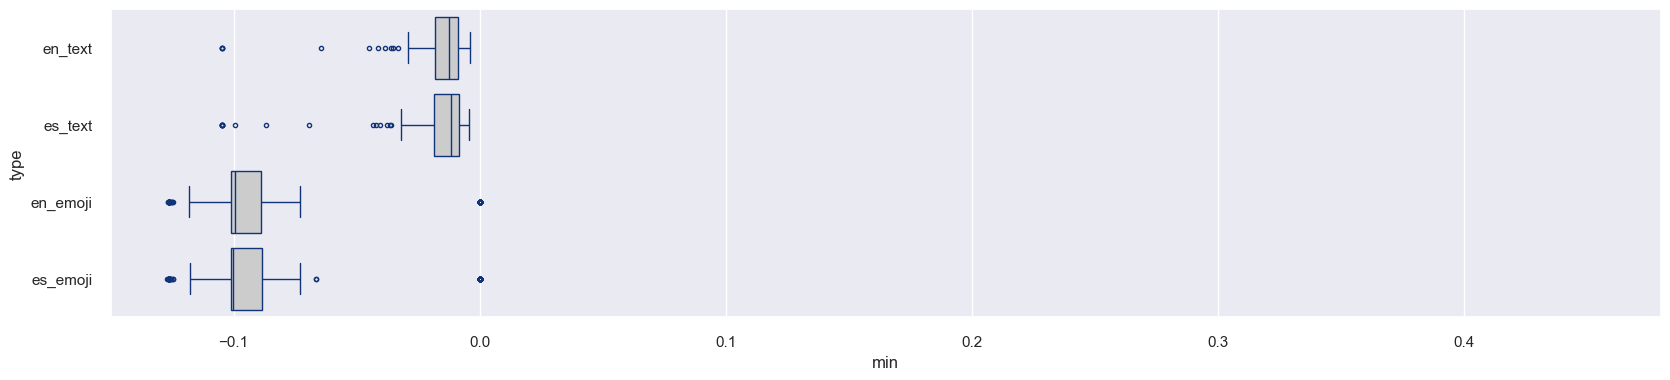

In [137]:
fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='min', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

(-0.15, 0.48)

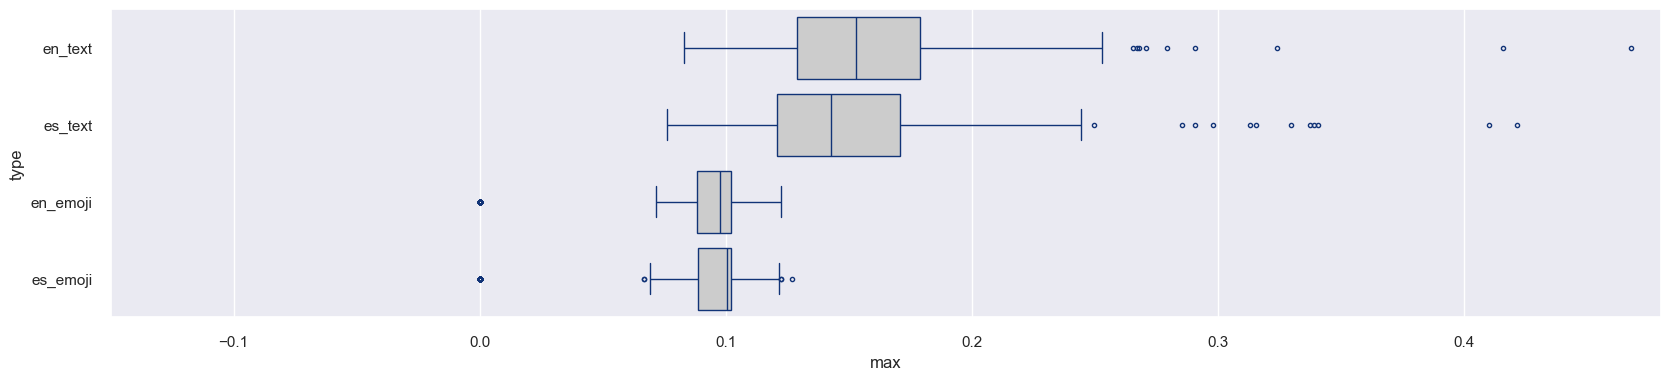

In [138]:
fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='max', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

## Variable names üìá
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)


## Try clustering using minibatch Kmeans -- concatenated word + emoji embeddings

In [24]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Determine optimal number of clusters

#### Distortion Score Elbow
- based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.

In [25]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


English

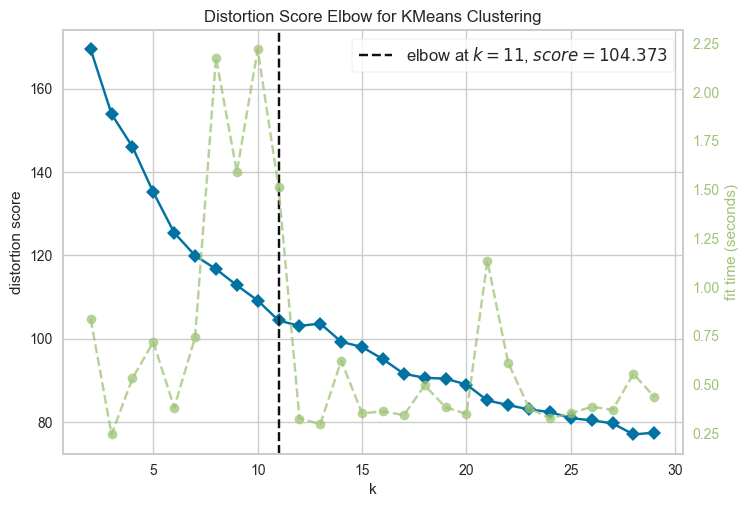

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

Spanish

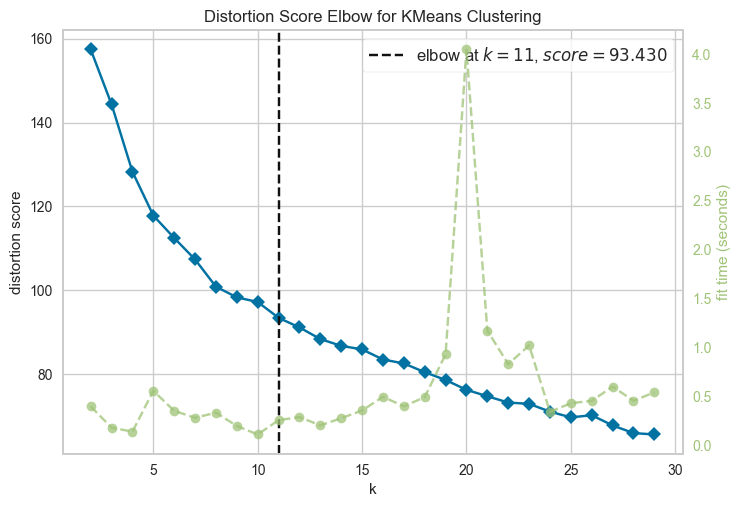

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#### Silhouette Coefficient Method

English

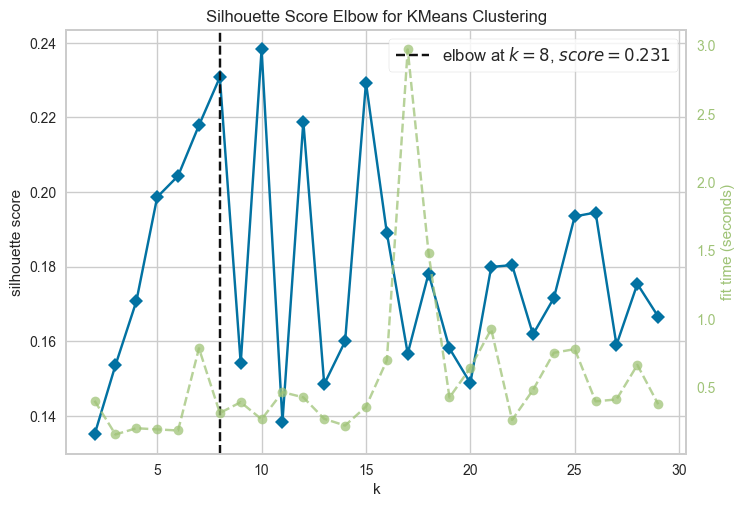

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [28]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Spanish

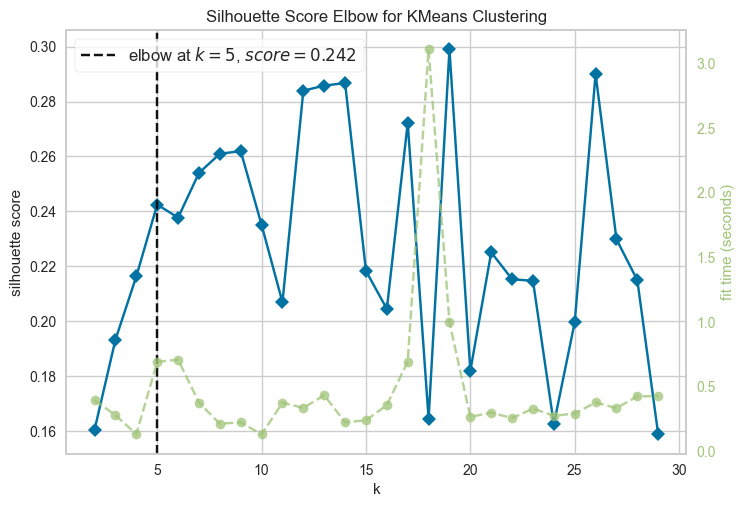

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(es_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Calinski-Harabasz Index

English

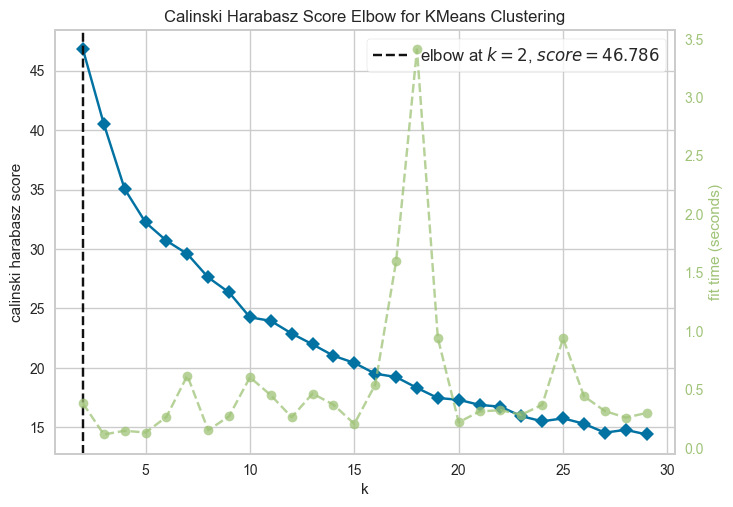

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [30]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Spanish

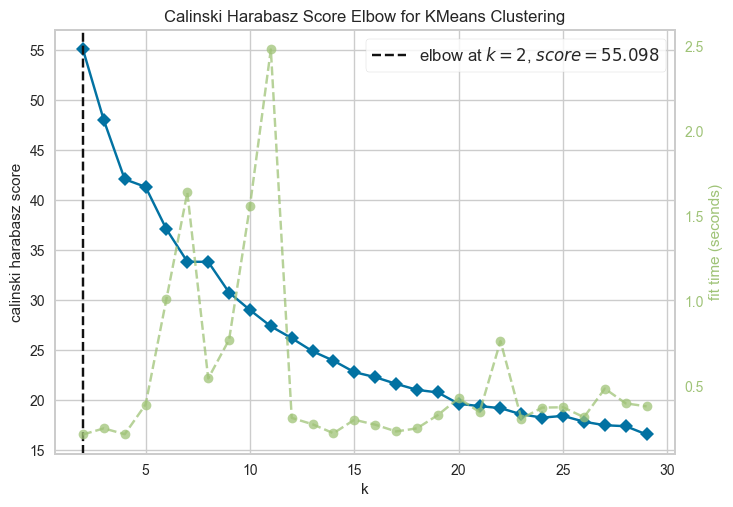

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [31]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(es_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Clustering Functions

In [32]:
# code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [33]:
def apply_cluster(lang_embeddings, lang_df, lang_filtered_comments, k):
    clustering, cluster_labels = mbkmeans_clusters(
        X=lang_embeddings,
        k=k,
        mb=500,
        print_silhouette_values=True,
    )
    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "tokens": [" ".join(text) for text in lang_filtered_comments],
        "cluster": cluster_labels
    })
    return df_clusters

### English Results

In [34]:
en_df_clusters = apply_cluster(en_embeddings, en_df, en_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.16
Inertia:106.87608377317548
Silhouette values:
    Cluster 10: Size:23 | Avg:0.46 | Min:0.17 | Max: 0.53
    Cluster 9: Size:6 | Avg:0.46 | Min:0.42 | Max: 0.49
    Cluster 7: Size:15 | Avg:0.44 | Min:0.20 | Max: 0.51
    Cluster 4: Size:7 | Avg:0.39 | Min:0.04 | Max: 0.46
    Cluster 2: Size:13 | Avg:0.35 | Min:0.18 | Max: 0.40
    Cluster 3: Size:24 | Avg:0.29 | Min:0.02 | Max: 0.46
    Cluster 0: Size:34 | Avg:0.26 | Min:0.05 | Max: 0.39
    Cluster 1: Size:29 | Avg:0.10 | Min:0.03 | Max: 0.19
    Cluster 5: Size:49 | Avg:0.08 | Min:-0.03 | Max: 0.21
    Cluster 8: Size:11 | Avg:0.03 | Min:-0.11 | Max: 0.10
    Cluster 6: Size:69 | Avg:-0.08 | Min:-0.26 | Max: -0.00


Top 3 English clusters

In [35]:
en_df_clusters[en_df_clusters['cluster']==4]['text'].tolist()

['the last one üíÄ',
 'All out lets add new people\n\nWhere is Son?\nHomeüíÄüíÄ',
 '@__oresec_ yo I‚Äôm back, we won against Spain üíÄ so good luck against Brazil',
 'bro peru wasnt even in the wcüíÄ',
 '@ludmilamasc someone DIDNT watch the match. shut up bruhüíÄ.',
 'They kostüíÄ',
 "Where's Korea? Airportttttt ‚ò†Ô∏è"]

In [36]:
en_df_clusters[en_df_clusters['cluster']==5]['text'].tolist()

['@bf_steve Who do you think I cheer for üòÇ',
 '@matheusgmezz u are goofy as hecküòÇ',
 '@jan_schawe to what üòÇüòÇüòÇüòÇüòÇ',
 '@dashotb the comment I was looking for üòÇ',
 'One Love üåà‚úñ üòÇüòÇüòÇ one two ‚úî ü§≠ü§≠ü§≠',
 'Why they burn Eden with the food question? üòÇ @albert810 @chelo23',
 '@exclusivelysania you are complaining in every post get a life üòÇ',
 '@afdhalulrizki42 üòÇ Stupid Football yes üòÇ',
 '@the_queen_of_adventure Haya bina ila lmondial üòÇüá®üá≤üòç',
 'Bro was forced to do itüòÇüòÇüòÇüòÇüòÇ',
 'Howtf is he the man of the match? üòÇ',
 'De Paul always with him üòÇ',
 'VAR only works for certain countries it seems üò¢',
 'African should stop joining FIFA games is such a shame awwüò¢üò¢üò¢üò¢',
 'I really wanna join them but I‚Äôm a Chineseüò≠üò≠üò≠',
 '@hamedsoltaniiiii67 take us out yourselves by winning üòÇ',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykunüòÇüòÇüòÇüòÇüòÇ',
 '@samiath_bk üòÇkeep laughing Senegal is

In [37]:
en_df_clusters[en_df_clusters['cluster']==3]['text'].tolist()

['@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTEüëèüî•',
 'Netherlandsüëèüëèüëè and also cricket',
 'Definitely!!! üëèüëèüëèüëèüëè',
 '@pr1ncesa_mar1 never! Korea is much better team! üëè',
 'He is completely right! üëè',
 'Brilliant player üëèüî•',
 'Shout out to my boy @richarlison with the best goal in this world cup 2022üëèüî•üáßüá∑üáßüá∑üáßüá∑üáßüá∑',
 '@hana_photographyc üòÇ Well done üëè',
 'hand ball üëè',
 'The Bluetooth goal üëè',
 '@itsabdelfatah you were right üëè',
 'üáπüá≥ ‚ù§Ô∏èüî• should be proud üëè',
 'That throw was litüëèüî•',
 'Congratulations üî•üëè',
 'respect üëè',
 'The Best goal of the world cupüëèüëèüëè‚öΩÔ∏è',
 'Just an amazing team great job üëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèª‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 '@reemasul_r3 there u go I told u guys yall can win too, good job üëèüèªüëèüèª u guys won fair and square, dont feel low for ur team. They are good e

### Spanish Results

Top 3 Spanish clusters

In [38]:
es_df_clusters = apply_cluster(es_embeddings, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.18
Inertia:107.28364930156687
Silhouette values:
    Cluster 5: Size:2 | Avg:0.49 | Min:0.49 | Max: 0.49
    Cluster 7: Size:12 | Avg:0.41 | Min:0.22 | Max: 0.47
    Cluster 0: Size:35 | Avg:0.40 | Min:0.06 | Max: 0.53
    Cluster 6: Size:22 | Avg:0.40 | Min:-0.02 | Max: 0.51
    Cluster 2: Size:56 | Avg:0.34 | Min:0.08 | Max: 0.43
    Cluster 3: Size:44 | Avg:0.16 | Min:0.01 | Max: 0.28
    Cluster 1: Size:26 | Avg:0.03 | Min:-0.05 | Max: 0.12
    Cluster 4: Size:83 | Avg:-0.07 | Min:-0.27 | Max: -0.00


In [39]:
pip install translate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [40]:
from translate import Translator

In [41]:
translator = Translator(from_lang="es", to_lang='en')
es_df_clusters['translation'] = es_df_clusters['text'].apply(lambda x: translator.translate(x))

In [42]:
es_df_clusters[es_df_clusters['cluster']==7]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==7]['text'].tolist()

['Nuestro √∫ltimo partido en un mundial üá®üá¥üò¢',
 'Como molan mis negritos üò¢',
 '@fifaworldcup Ecuador se merec√≠a el pase üò¢',
 'A√∫n dueleüò¢',
 'y mechico?üò¢',
 '@guiguelpaulo üò¢',
 'Merecias ganar japon üò¢',
 'Neymar Da Silva Santos Junior üò¢',
 '@mdsojid364 llora brasile√±o üò¢',
 'Casillas lloronüò¢',
 'Jam√°s pens√© que un mundial del cu√°l tantas personas esperaban ver calidad est√© siendo tan manipulado y arreglado c√≥mo est√©, quer√≠amos ver transparencia con buenos jugadores dej√°ndolo todo en la cancha pero al final solo hemos visto fraude,mentiras y enga√±√≥ con la mayor√≠a de equipos que han salido, hasta los √°rbitros parecen comprados porque han pitado penaltis inexistente para favorecer a los equipos que deseaban ver en la final, QUE TRISTEZA EST√â MUNDIAL DE QATAR 2022 üò¢üò¢üò¢.',
 'La final la juegan 2 equipos......que gran decepci√≥n este mundial üò¢']

In [43]:
t7 = ['With everything maes üî•üá®üá∑','The master magicianüî•üî•  üëèüèª‚ö°',
 'We love you @yosoy8a üá≤üáΩüî•',
 'Let\'s go Spain üî•',
 'Life changes when it starts to focus on youüé∂üî•',
 '@sandra_cariel cameeron 100% √©liminer üî•üî•',
 '@hoonjy you guys, if those shots didn\'t hit the stick uffffüî•',
 'It will be that they break the curseüî•üî•üî•',
 'Valenciaüî•üî•üî•',
 'All my faith for Argentina üî•',
 '@pablogavi good lucküî•',
 '@deyaneira_ae what a qualification Valencia gave in Senegal\'s 2nd goalüôåüî•üî•',
 'The MESSIAS is back üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑ Let\'s go Selection üî•üî•üî•',
 'Ronaldoüî•üî•üî•üî•',
 'Aidouniüî•‚ù§Ô∏è',
 '@hilla_loaiza what level üî•üî•üî•',
 'What a great game from this manüî•',
 'Argentina üî•üíö',
 'Trioos are always good bro üî•üòâ',
 'The best in the world! ‚ù§Ô∏è\u200düî•‚ù§Ô∏è\u200düî•',
 'üòç√±üî•üî•üî•',
 'ComOn Argentina..you can do it üî•‚ù§Ô∏èüî•',
 'Let\'s go Argentina üî•üî•',
 'It was an exquisite match üî•',
 'Argentina wins üî•üî•üî•‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 'üî•üî•üî•üëèüôå mexico üá≤üáΩ',
 'Argentina, Alvaresüî•',
 'üî•Argentina. 3 üî• France 1üî•',
 'Argentina üòç‚ù§Ô∏èüî•üî•',
 'Roberto üî•üî•']
t7

['With everything maes üî•üá®üá∑',
 'The master magicianüî•üî•  üëèüèª‚ö°',
 'We love you @yosoy8a üá≤üáΩüî•',
 "Let's go Spain üî•",
 'Life changes when it starts to focus on youüé∂üî•',
 '@sandra_cariel cameeron 100% √©liminer üî•üî•',
 "@hoonjy you guys, if those shots didn't hit the stick uffffüî•",
 'It will be that they break the curseüî•üî•üî•',
 'Valenciaüî•üî•üî•',
 'All my faith for Argentina üî•',
 '@pablogavi good lucküî•',
 "@deyaneira_ae what a qualification Valencia gave in Senegal's 2nd goalüôåüî•üî•",
 "The MESSIAS is back üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑ Let's go Selection üî•üî•üî•",
 'Ronaldoüî•üî•üî•üî•',
 'Aidouniüî•‚ù§Ô∏è',
 '@hilla_loaiza what level üî•üî•üî•',
 'What a great game from this manüî•',
 'Argentina üî•üíö',
 'Trioos are always good bro üî•üòâ',
 'The best in the world! ‚ù§Ô∏è\u200düî•‚ù§Ô∏è\u200düî•',
 'üòç√±üî•üî•üî•',
 'ComOn Argentina..you can do it üî•‚ù§Ô∏èüî•',
 "Let's go Argen

In [44]:
# es_df_clusters[es_df_clusters['cluster']==1]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==4]['text'].tolist()

['Orgullosamente Ecuatorianos üòç',
 'Felicidades Ecuador! üôå',
 '@alvarodnl Si no vemos el mundial, Qatar pierde plata q gan√≥ dejando a personas morir üôÉ',
 'Corrupci√≥n üí∞üí∞üí∞üí∞',
 '@ikercasillasrules No veo donde sale neuer en el video üòÆ',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è Ecuatorianos üòçüòçüòçüòçüòç',
 'I need an ice Pepsi Blue üòãüòãüòãüòãüòã joder, ser√° que este a√±o no la  lanzar√°n??? ü§îü§îü§î',
 '@btito_.avak mejor portero del mundo, procede a perder 7 a 0üòçüòçüòç',
 'Eden hazard comes backüòçüòçüòç',
 'love banget idola saya portugal - cristiano ronaldo.üòç',
 'Vamos Espana üôå',
 'ya esta viejo el cucho ‚òπ‚òπ',
 'Pero no hicieron nada hoy...Qu√© partido m√°s aburrido üòí',
 'Siempre me han gustado lo uniformes de ghanaüòç',
 '@bbsitaj ya vamos a ver el 18 de diciembre üòâ',
 'Nadie va a comentar la facha que destila el DT de la selecci√≥n? üåöüòà',
 '@jl5759600 telo sico ü§´ü§ê',
 'Hola Buena noche es Portugal ‚öΩÔ∏èüëç

In [45]:
t4 = ['Proudly Ecuadorians üòç',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è Ecuadorians üòçüòçüòçüòçüòç',
 '@btito_.avak best goalkeeper in the world, proceeds to lose 7 to 0üòçüòçüòç',
 'Eden hazard comes backüòçüòçüòç',
 'love banget idola saya portugal - Cristiano Ronaldo.üòç',
 'I have always liked Ghanaian uniformsüòç',
 'Love the France shirt üòçüòçüòç üá∫üáæüá®üáµ',
 'Lol Casillas!!! üòçüòç',
 'thank you üòç',
 '@sebassss_07 our goal is to win the world championships, not to participate üòò',
 'üòçronaldo']
t4

['Proudly Ecuadorians üòç',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è Ecuadorians üòçüòçüòçüòçüòç',
 '@btito_.avak best goalkeeper in the world, proceeds to lose 7 to 0üòçüòçüòç',
 'Eden hazard comes backüòçüòçüòç',
 'love banget idola saya portugal - Cristiano Ronaldo.üòç',
 'I have always liked Ghanaian uniformsüòç',
 'Love the France shirt üòçüòçüòç üá∫üáæüá®üáµ',
 'Lol Casillas!!! üòçüòç',
 'thank you üòç',
 '@sebassss_07 our goal is to win the world championships, not to participate üòò',
 'üòçronaldo']

In [46]:
# es_df_clusters[es_df_clusters['cluster']==8]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==1]['text'].tolist()

['@magggitomcruz ya estamos en la copa, se llama USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ',
 'Osea el uno tapa penal el otro hace gol y este es el mejor del partido es lo de ayer Ferr√°n hizo los 2 goles y grande jugadas y el mejor fue Gavi üòÇüòÇ',
 'Ecuador los hizo bailar los humill√≥ y supuestamente este qued√© como mejor jugador üòÇ tras que anulan  un gol leg√≠timo, tambi√©n meten mano en el mejor jugador cuando todo el mundo se di√≥ cuenta perfectamente que Ecuador los super√≥, que descarados que son',
 'Los de Arabia Saud√≠ se quieren morir estaban contentos porque nos ganaron el primer partido üòÇüòÇüòÇ vamos Argentina üá¶üá∑üá¶üá∑',
 '@chucuzilla la mas grande conquista de Vargentina against Brasil ? üòÇüëåüèº Pel√© es maior que l√° Vargentina üòÇ',
 '@yer_gamboa irse es irse jaja preguntale a Uruguay jaja crees que les importa irse con la cara en alto jaja se fueron llorando queriendo golpear a los √°rbitros... Igual cada quien sus aspiraciones jaja ya si Jap√≥n es c

In [47]:
t1 = ['How seductive the one in the second photo üòÇüòÇ',
 '@magggitomcruz we are already in the cup, it\'s called USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ',
 'I mean, one blocks a penalty, the other scores a goal and this is the best of the game, it\'s what happened yesterday, Ferr√°n scored the 2 goals and great plays and the best was Gavi üòÇüòÇ',
 '@daje_mitico üòÇüòÇ',
 '@lauhernandezchavez La Payasada was expensive for them üòÇ',
 'Poor guy üòÇ',
 'Ecuador made them dance, humiliated them and supposedly this was the best player üòÇ after they annulled a legitimate goal, they also put their hands on the best player when everyone realized perfectly well that Ecuador surpassed them, how shameless they are',
 'üòÇRonaldo',
 'A cockroach moves more with baygonüòÇ',
 '@jomiguelrivera we scored the goal of the century against ItalyüòÇ',
 'What a good deal for our team üòÇ',
 'Shit üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 '@bertonrayhs_ üòÇüòÇüòÇyou have it insideüá¶üá∑üá¶üá∑',]
t1

['How seductive the one in the second photo üòÇüòÇ',
 "@magggitomcruz we are already in the cup, it's called USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ",
 "I mean, one blocks a penalty, the other scores a goal and this is the best of the game, it's what happened yesterday, Ferr√°n scored the 2 goals and great plays and the best was Gavi üòÇüòÇ",
 '@daje_mitico üòÇüòÇ',
 '@lauhernandezchavez La Payasada was expensive for them üòÇ',
 'Poor guy üòÇ',
 'Ecuador made them dance, humiliated them and supposedly this was the best player üòÇ after they annulled a legitimate goal, they also put their hands on the best player when everyone realized perfectly well that Ecuador surpassed them, how shameless they are',
 'üòÇRonaldo',
 'A cockroach moves more with baygonüòÇ',
 '@jomiguelrivera we scored the goal of the century against ItalyüòÇ',
 'What a good deal for our team üòÇ',
 'Shit üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 '@bertonrayhs_ üòÇüòÇüòÇyou have it insideüá¶üá∑üá¶üá∑']

## Clustering with LASER Embeddings on text only

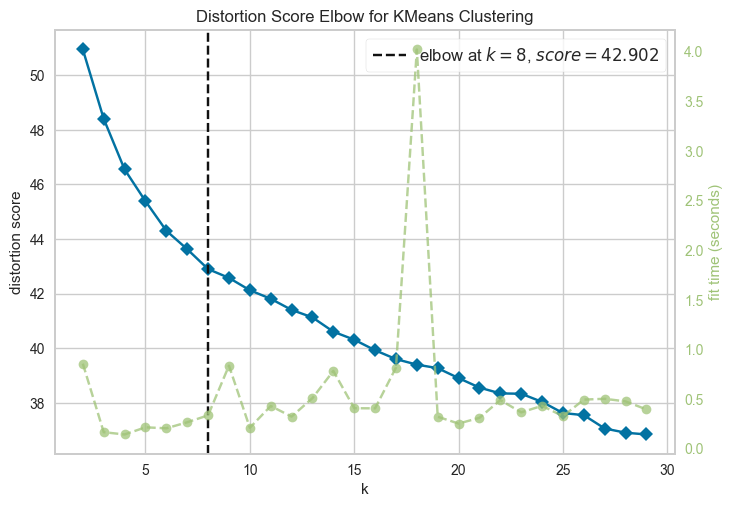

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_text_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [49]:
en_df_clusters_laser = apply_cluster(en_text_array, en_df, en_filtered_comments, 10)

For n_clusters = 10
Silhouette coefficient: 0.03
Inertia:42.707401275634766
Silhouette values:
    Cluster 5: Size:16 | Avg:0.22 | Min:0.07 | Max: 0.34
    Cluster 8: Size:20 | Avg:0.09 | Min:-0.04 | Max: 0.22
    Cluster 3: Size:43 | Avg:0.09 | Min:-0.02 | Max: 0.13
    Cluster 7: Size:22 | Avg:0.05 | Min:-0.02 | Max: 0.10
    Cluster 6: Size:6 | Avg:0.02 | Min:-0.04 | Max: 0.06
    Cluster 0: Size:26 | Avg:0.00 | Min:-0.05 | Max: 0.06
    Cluster 1: Size:11 | Avg:-0.01 | Min:-0.09 | Max: 0.03
    Cluster 9: Size:40 | Avg:-0.01 | Min:-0.06 | Max: 0.06
    Cluster 2: Size:33 | Avg:-0.01 | Min:-0.06 | Max: 0.04
    Cluster 4: Size:63 | Avg:-0.02 | Min:-0.08 | Max: 0.06


In [50]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==3]['text'].tolist()

['We are ready üíõüíô‚ù§Ô∏è',
 'üëèüòÑ next game please..‚öΩüèÉ',
 '@smithswith_ ‚ù§Ô∏èso good!!',
 '@jan_schawe to what üòÇüòÇüòÇüòÇüòÇ',
 '@5400.seconds are u there bro? ü§£',
 'Italy >>‚ù§Ô∏è',
 'Mount‚ù§Ô∏è',
 'Best player üî•üî•',
 'He is completely right! üëè',
 'Brilliant player üëèüî•',
 'My Favorite team üî•üî•',
 '@hana_photographyc üòÇ Well done üëè',
 '@_hey.its.sup_ we did it üòâüôå',
 'hand ball üëè',
 '@realestate_topg what happened ü§£ü§£',
 '@itsabdelfatah you were right üëè',
 'Nice game üî•',
 '@beatbox_musicality For real broüî•üî•üî•',
 '@kourosh_offiziell üáßüá∑üáßüá∑üèÜüèÜüèÜüèÜüèÜ ü§´',
 '@ban_all_mondays verpiss dich goodbyeüòÇ',
 'the last one üíÄ',
 '@joyce_pecky they were well playedüôåüèªüôåüèª',
 '@memphis is a lion ü¶Åü¶Åü¶Å',
 '@richard.escobarc by üòÇüòÇüá≤üá¶üí™',
 '@afaseleccion come back matchüí•üí•üí•',
 '@m.a.l.e.k.a.n.o_jr Just waitüî•',
 'Japan played better üò¢',
 'Var üñ• have another 

In [51]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==4]['text'].tolist()

['@bf_steve Who do you think I cheer for üòÇ',
 'Fantastis group..‚úåüòÑ',
 'Netherlandsüëèüëèüëè and also cricket',
 'This nikka sick wit itüî•üòÇ',
 '@goodthanksyourself nice goal‚ù§Ô∏è',
 '@matheusgmezz u are goofy as hecküòÇ',
 '@dashotb the comment I was looking for üòÇ',
 'One Love üåà‚úñ üòÇüòÇüòÇ one two ‚úî ü§≠ü§≠ü§≠',
 'We love you hazardsüî•üî•üî•',
 'Gay people, they are my favorite üåàüåà',
 '@afdhalulrizki42 üòÇ Stupid Football yes üòÇ',
 '@the_queen_of_adventure Haya bina ila lmondial üòÇüá®üá≤üòç',
 'Bro was forced to do itüòÇüòÇüòÇüòÇüòÇ',
 '@pr1ncesa_mar1 never! Korea is much better team! üëè',
 'dats literally my dad üî•',
 'VAR only works for certain countries it seems üò¢',
 'Morroco is the best üá≤üá¶üñ§',
 'Proudly Ghanaian üá¨üá≠ üá¨üá≠ üá¨üá≠ üá¨üá≠ üá¨üá≠ ‚ù§Ô∏è',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykunüòÇüòÇüòÇüòÇüòÇ',
 '@samiath_bk üòÇkeep laughing Senegal is the best',
 'Musiala all the wayüî•'

In [52]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==6]['text'].tolist()

["Can't wait for this shitshow to be over and for next world cup. This one is such a waste üóë üôÑ. #nextplease #notoqatar2022 #boicotworldcup",
 'Congrats and well done toüáßüá™@belgianreddevils who wins and wish the best and good luck too in the next match againstüá≤üá¶@equipedumaroc and forüá®üá¶@canadasoccer ,well done for fights until the end despite lost and wish the best and good luck too in the next match againstüá≠üá∑@hns_cff !üëèüôÇüòÄüòÑüòéüëç‚öΩÔ∏è',
 'Dude‚Ä¶ YOUR team was so rude and had poor sportsmanship. This new generation think they are entitledüò° Any other country would have been honored to be in the world cup to play on the same field with these GREAT players from üá≠üá∑ \n\nI hope this humbles them. Canada player were acting like little brats. Croatia shut them up and put them on time out. Literally OUTüòÇüí™üèªüá≠üá∑üá≠üá∑üá≠üá∑üá≠üá∑üá≠üá∑üá≠üá∑üèÜüèÜüèÜüèÜ‚öΩÔ∏è‚öΩÔ∏è‚öΩÔ∏èüá≠üá∑üá≠üá∑üá≠üá∑üá≠üá∑üá≠üá∑üá≠üá∑ü

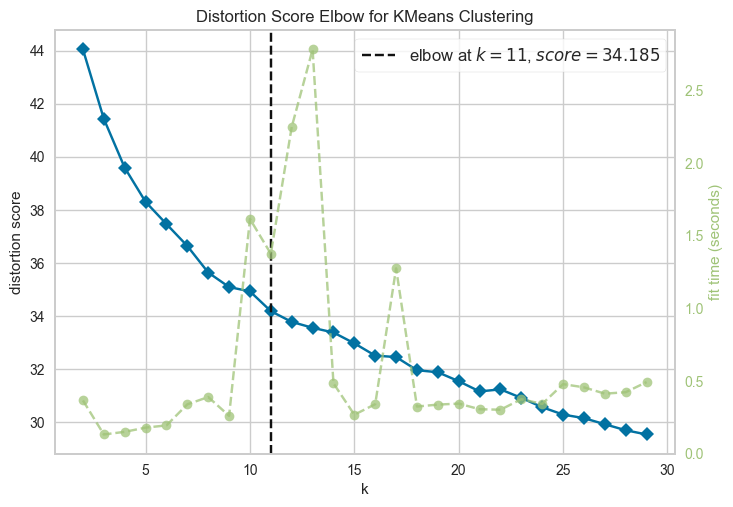

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_text_array)        # Fit data to visualizer
visualizer.show()     

In [54]:
es_df_clusters_laser = apply_cluster(es_text_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.05
Inertia:36.20710754394531
Silhouette values:
    Cluster 3: Size:31 | Avg:0.21 | Min:0.06 | Max: 0.34
    Cluster 5: Size:8 | Avg:0.15 | Min:-0.06 | Max: 0.25
    Cluster 1: Size:43 | Avg:0.07 | Min:-0.00 | Max: 0.17
    Cluster 0: Size:58 | Avg:0.07 | Min:-0.03 | Max: 0.13
    Cluster 7: Size:27 | Avg:0.02 | Min:-0.06 | Max: 0.11
    Cluster 2: Size:75 | Avg:0.00 | Min:-0.07 | Max: 0.08
    Cluster 4: Size:34 | Avg:-0.01 | Min:-0.09 | Max: 0.04
    Cluster 6: Size:4 | Avg:-0.02 | Min:-0.05 | Max: 0.01


In [55]:
# es_df_clusters_laser['translation'] = es_df_clusters_laser['text'].apply(lambda x: translator.translate(x))

In [56]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==3]['text'].tolist()

['Corrupci√≥n üí∞üí∞üí∞üí∞',
 'üëèüëèüôåüôåEcuador',
 '@jctorr130 1-1ü§´ü§´ü§´ü§´',
 'Ronaldoüôåüî•',
 '@daje_mitico üòÇüòÇ',
 'Mechico ü§èüèº',
 'üòÇ Ronaldo',
 'Valenciaüî•üî•üî•',
 '@andamente enormes üôåüèº',
 'gracias üòç',
 '@luisitorres_ s√≠ ü•µ',
 'Mierda üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ',
 'Ronaldoüî•üî•üî•üî•',
 'El Pl√°stico üôå',
 '@guiguelpaulo üò¢',
 'Argentina üî•üíö',
 '@caro2653 üëèüëèüëè',
 '@_arabicqueen_ dreamüòÇüòÇ',
 'el mayor ü§©ü§©',
 'üòç√±üî•üî•üî•',
 'Croacia üòÇüòÇüòÇüòÇüòÇ',
 'Nanicos‚≠ê‚≠êü§è',
 'Paquet√° ü•µ',
 '@acdc.jpedro üòÇüòÇüòÇüòÇüòÇ',
 '@liga_profesional_de_truco üëçüèª',
 'üòçronaldo',
 '@b.local üòÇüòÇüòÇüëè',
 '@maxirodriguez11oficial genio!!! üëèüëèüëèüëèüíôü§çüíô',
 'Marrocosüëèüëèüëêüëê',
 'Roberto üî•üî•',
 '@laparra_1 üëÄ']

In [57]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==1]['text'].tolist()

['Vamos con todo üá®üá∑‚ô•Ô∏è‚öΩÔ∏è',
 'Ecuador! üá™üá®üá™üá®üá™üá®üá™üá®‚ù§‚ù§',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è Ecuatorianos üòçüòçüòçüòçüòç',
 'Cambien la bandera, somos Ecuador üá™üá®‚òùüèª',
 'Con todo maes üî•üá®üá∑',
 'Nuestro √∫ltimo partido en un mundial üá®üá¥üò¢',
 'Go Ecuador üá™üá®‚ù§Ô∏è',
 'Vamooo Halc√≥n ü¶Ö üá∫üáæ',
 'Hola Buena noche es Portugal ‚öΩÔ∏èüëçüáµüáπ',
 'Ame la camiseta de Francia üòçüòçüòç üá∫üáæüá®üáµ',
 '@hichemourad13 ser√° que sigue pensado igual este individuo?  Ecuador es grande üá™üá®üòâüòâ',
 'Para mi tambi√©n ser√≠a como ver a Papa Noel! Te amamos Leo üá¶üá∑‚öΩÔ∏èüí™ü•∞',
 'An√≥talo papi .....Vamos Ecuador üá™üá®ü•∞‚ù§Ô∏è‚ù§Ô∏è',
 'Ecuador presente üá™üá®üëèüëè',
 'El gol del siglo üá®üá∑\U0001fae1',
 'Ecuador üá™üá® ‚ù§Ô∏è#win',
 '@bertonrayhs_ üòÇüòÇüòÇla tenes adentroüá¶üá∑üá¶üá∑',
 '@sujo.beatz y nosotros 25 t√≠tulos üèÜ somos la selecci√≥n m√°s coperaüá¶üá∑',
 'üï∏Ô∏è

## Clustering with LASER Embeddings on text + emoji

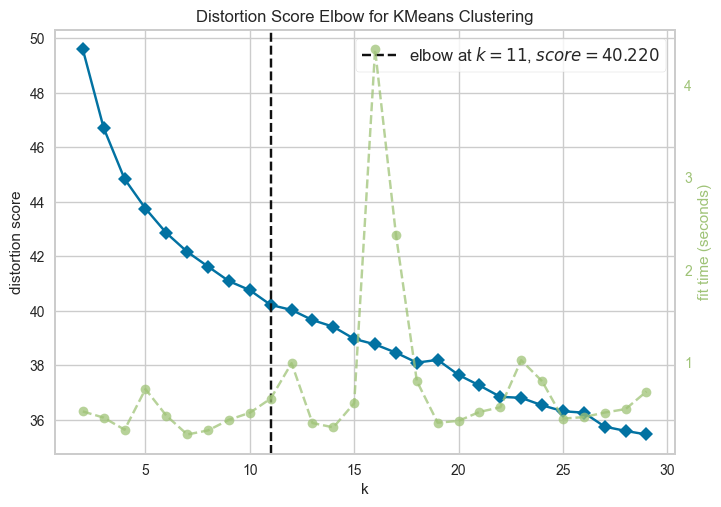

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [59]:
en_df_clusters_laser_with_emoji = apply_cluster(en_array, en_df, en_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.04
Inertia:41.72456359863281
Silhouette values:
    Cluster 4: Size:5 | Avg:0.17 | Min:0.06 | Max: 0.27
    Cluster 5: Size:38 | Avg:0.17 | Min:0.08 | Max: 0.29
    Cluster 2: Size:64 | Avg:0.08 | Min:-0.03 | Max: 0.16
    Cluster 6: Size:13 | Avg:0.04 | Min:-0.01 | Max: 0.09
    Cluster 0: Size:42 | Avg:0.02 | Min:-0.07 | Max: 0.10
    Cluster 7: Size:27 | Avg:-0.00 | Min:-0.06 | Max: 0.03
    Cluster 3: Size:45 | Avg:-0.02 | Min:-0.10 | Max: 0.06
    Cluster 1: Size:46 | Avg:-0.03 | Min:-0.09 | Max: 0.04


In [60]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==1]['text'].tolist()

["Can't wait for this shitshow to be over and for next world cup. This one is such a waste üóë üôÑ. #nextplease #notoqatar2022 #boicotworldcup",
 'You are the best ladyüòªü§©üôèüëè‚ô•Ô∏è‚öΩü§†fifa.',
 '@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTEüëèüî•',
 'Rainbow üåàüåàüåà shame on fifa',
 'Yes 2022 is different because Argentina will not go in round of 16 üòÇ',
 'no bro many moroccans respect Croatia team, was a game full of fair-play üëåüèΩ',
 'Wtf Mbappe wasn‚Äôt even the man of the match ü§¶üèª\u200d‚ôÇÔ∏è',
 "@shintia97s love over hate !! I'm sorry that you've got so much anger inside for another human. But I forgive you and send you love and support. ü´Çü´Çü§óü§óüòòüòòüè≥Ô∏è\u200düåàüè≥Ô∏è\u200düåà",
 'But you start to tremble knowing you face Saudi Arabia üá∏üá¶ üòÜ',
 "Hazard's the only reason im a chelsea fan üêêüíô",
 '@gokselinia they all good, u are the one being racist u woman with cartoon tshirt or I sa

In [61]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==5]['text'].tolist()

['Sonü•∫',
 '@_francechy_ ü§£ü§£ü§£',
 '@goodthanksyourself nice goal‚ù§Ô∏è',
 '@smithswith_ ‚ù§Ô∏èso good!!',
 '@jan_schawe to what üòÇüòÇüòÇüòÇüòÇ',
 '@5400.seconds are u there bro? ü§£',
 'Italy >>‚ù§Ô∏è',
 'Mount‚ù§Ô∏è',
 'He is completely right! üëè',
 '@hana_photographyc üòÇ Well done üëè',
 '@_hey.its.sup_ we did it üòâüôå',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykunüòÇüòÇüòÇüòÇüòÇ',
 'hand ball üëè',
 'Rushford üî•',
 '@realestate_topg what happened ü§£ü§£',
 'Loveee this ‚ù§Ô∏è',
 '@itsabdelfatah you were right üëè',
 'CR7 ‚ù§Ô∏èüôå',
 'Nice game üî•',
 '@kourosh_offiziell üáßüá∑üáßüá∑üèÜüèÜüèÜüèÜüèÜ ü§´',
 '@anchan_0722_ üòÇüòÇüòÇ',
 '@88godiswithme üòÇüòÇüòÇüòÇüòÇüòÇüòÇ congratulations!!',
 'the last one üíÄ',
 'Congratulations üî•üëè',
 'respect üëè',
 'Coolüî•',
 '@spasho05 üòÇüòÇüòÇüòÇ',
 '@m.a.l.e.k.a.n.o_jr Just waitüî•',
 'HE SO FINE OMLL üòç',
 '@its_romay üò¢ me rn',
 'Caption üíØ',
 '@robertmikocevic 

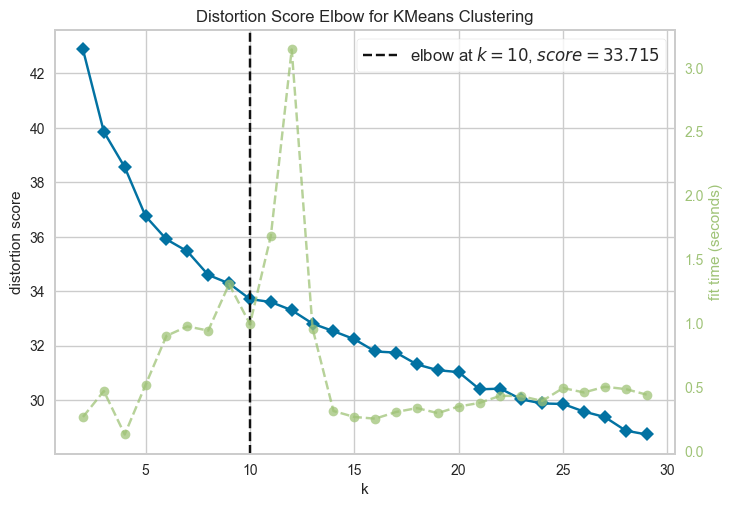

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [63]:
es_df_clusters_laser_with_emoji = apply_cluster(es_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.03
Inertia:35.527523040771484
Silhouette values:
    Cluster 0: Size:12 | Avg:0.18 | Min:0.06 | Max: 0.30
    Cluster 6: Size:10 | Avg:0.13 | Min:-0.13 | Max: 0.26
    Cluster 5: Size:10 | Avg:0.13 | Min:0.07 | Max: 0.20
    Cluster 3: Size:56 | Avg:0.09 | Min:-0.02 | Max: 0.19
    Cluster 7: Size:52 | Avg:0.06 | Min:-0.04 | Max: 0.13
    Cluster 2: Size:55 | Avg:-0.02 | Min:-0.09 | Max: 0.04
    Cluster 1: Size:55 | Avg:-0.04 | Min:-0.19 | Max: 0.09
    Cluster 4: Size:30 | Avg:-0.05 | Min:-0.13 | Max: 0.03


In [64]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==3]['text'].tolist()

['Vamos con todo üá®üá∑‚ô•Ô∏è‚öΩÔ∏è',
 'Corrupci√≥n üí∞üí∞üí∞üí∞',
 'Con todo maes üî•üá®üá∑',
 'üëèüëèüôåüôåEcuador',
 '@jctorr130 1-1ü§´ü§´ü§´ü§´',
 'Go Ecuador üá™üá®‚ù§Ô∏è',
 'Ronaldoüôåüî•',
 'Eden hazard comes backüòçüòçüòç',
 '¬°El mago maestroüî•üî•ü§çüëèüèª‚ö°',
 'Te amamos @yosoy8a üá≤üáΩüî•',
 'Mechico ü§èüèº',
 '@jl5759600 telo sico ü§´ü§ê',
 'Vamooo Halc√≥n ü¶Ö üá∫üáæ',
 'Hola Buena noche es Portugal ‚öΩÔ∏èüëçüáµüáπ',
 '@sandra_cariel cameeron 100% √©liminer üî•üî•',
 '15 mundiales üëèüëèüëè',
 'Seraaa que rompen la maldici√≥nüî•üî•üî•',
 'Valenciaüî•üî•üî•',
 'Lol Casillas!!! üòçüòç',
 '_Marocooüá≤üá¶ü´Ä_',
 'Ecuador presente üá™üá®üëèüëè',
 'El gol del siglo üá®üá∑\U0001fae1',
 '"Maurice ya no puedo moverlo mover moverlo" ‚ùåü¶µüò≠',
 '@andamente enormes üôåüèº',
 'Ecuador üá™üá® ‚ù§Ô∏è#win',
 '@bertonrayhs_ üòÇüòÇüòÇla tenes adentroüá¶üá∑üá¶üá∑',
 'üï∏Ô∏èü§üüèªüá¶üá∑ La ara√±a que pica @ju

In [65]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==4]['text'].tolist()

['Cambien la bandera, somos Ecuador üá™üá®‚òùüèª',
 'Felicidades a Ecuador por ganarle a los esclavistas üëèüèºüëèüèº',
 'love banget idola saya portugal - cristiano ronaldo.üòç',
 '@magggitomcruz ya estamos en la copa, se llama USA üá∫üá∏ lmao p3nd3j0 üòÇüòÇ',
 '@hichemourad13 ser√° que sigue pensado igual este individuo?  Ecuador es grande üá™üá®üòâüòâ',
 'Toda m√≠ fe para la Argentina üî•',
 '@borenia grs!!! üî•üôå‚ù§Ô∏è futbol es f√∫tbol',
 'An√≥talo papi .....Vamos Ecuador üá™üá®ü•∞‚ù§Ô∏è‚ù§Ô∏è',
 '@deyaneira_ae que habilitacion se mando valencia en el 2do gol de Senegalüôåüî•üî•',
 '@sujo.beatz y nosotros 25 t√≠tulos üèÜ somos la selecci√≥n m√°s coperaüá¶üá∑',
 'Maradona lo ayudar a Messi para lograr el triunfo ‚ù§Ô∏èüëèüëèüëè',
 '@chucuzilla la mas grande conquista de Vargentina against Brasil ? üòÇüëåüèº Pel√© es maior que l√° Vargentina üòÇ',
 'Los trios siempre son buenos bro üî•üòâ',
 'Argentina üá¶üá∑üá¶üá∑üí•üí•üíô',
 '@memphisde

# Visualize Clusters üé®

In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### English

In [72]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(en_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

en_df_clusters = en_df_clusters.reset_index()
en_df_clusters = en_df_clusters.drop(['index'], axis=1)

tsne_df = en_df_clusters
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

<Axes: xlabel='PC1', ylabel='PC2'>

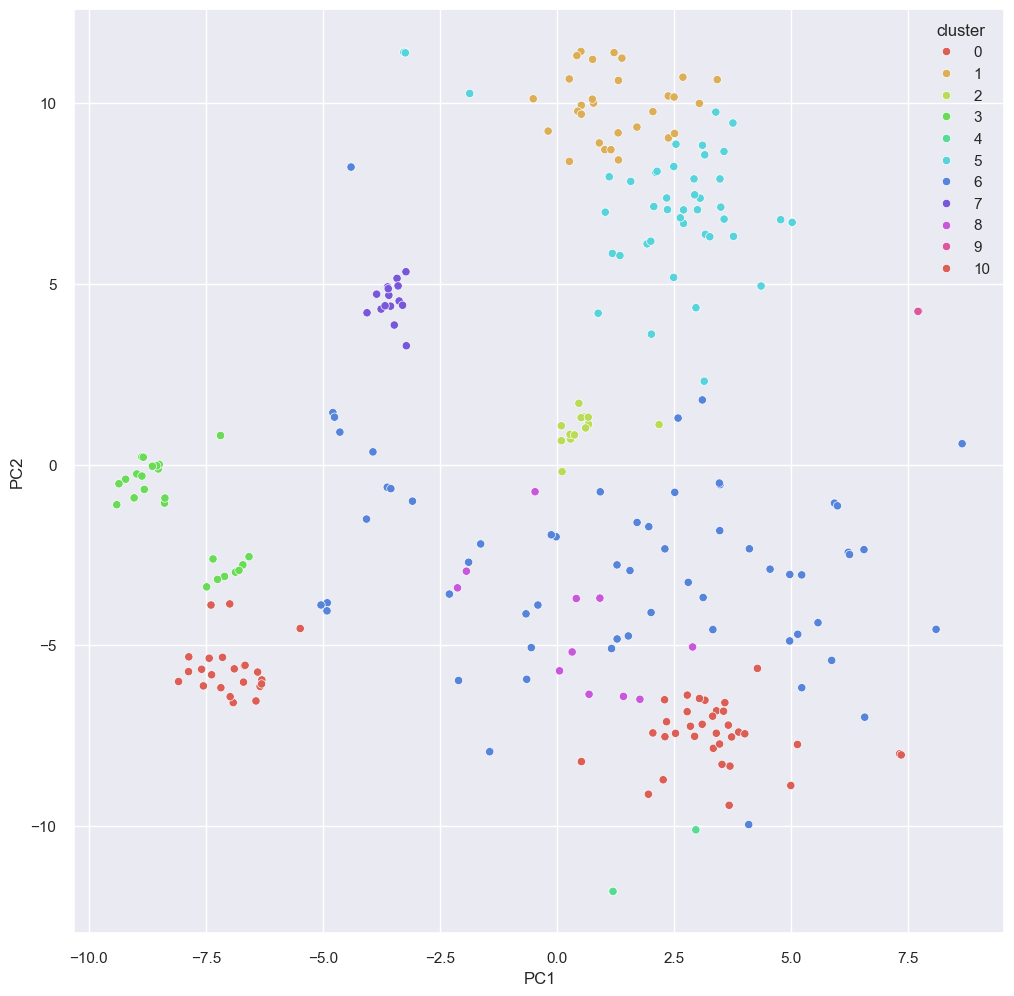

In [73]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='cluster', palette=sns.color_palette("hls",10), legend="full")

#### Spanish

In [74]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(es_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

es_df_clusters = es_df_clusters.reset_index()
es_df_clusters = es_df_clusters.drop(['index'], axis=1)

tsne_df = es_df_clusters
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

<Axes: xlabel='PC1', ylabel='PC2'>

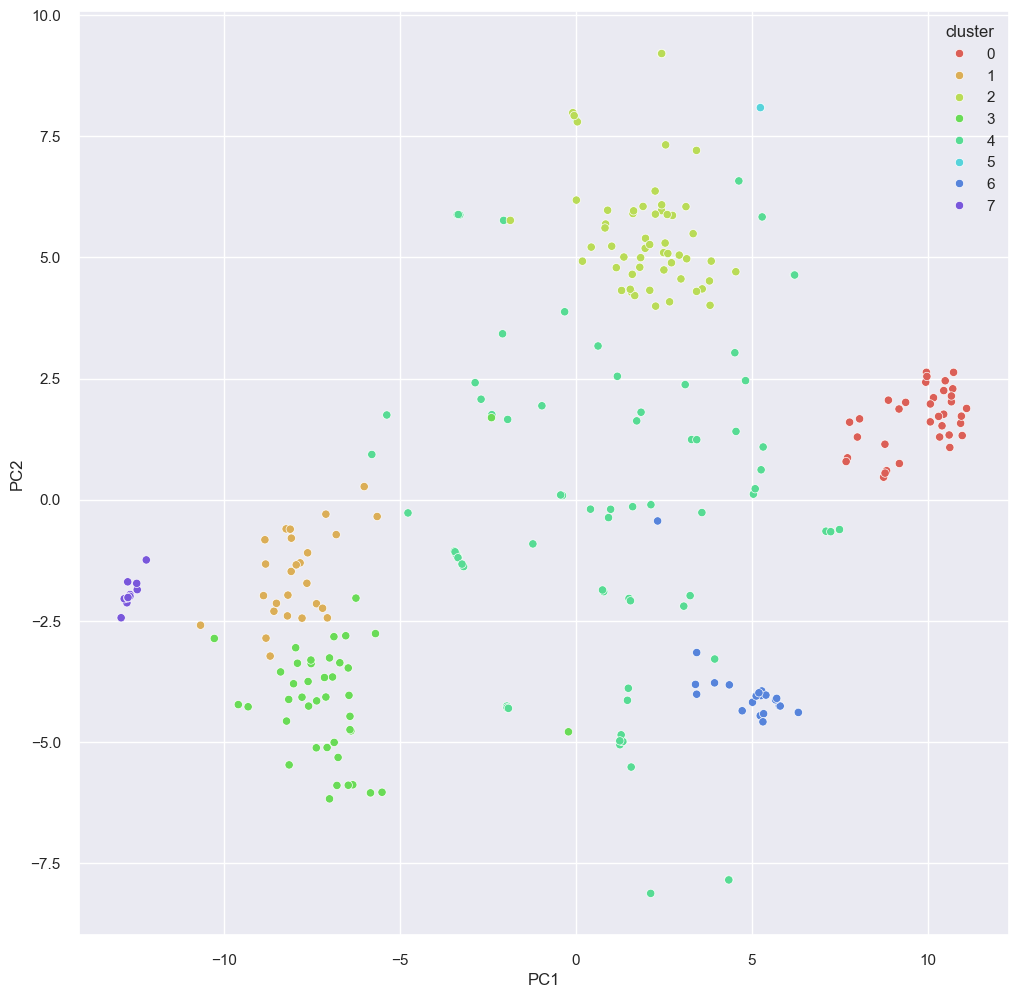

In [75]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='cluster', palette=sns.color_palette("hls",10), legend="full")

<Axes: xlabel='PC1', ylabel='PC2'>

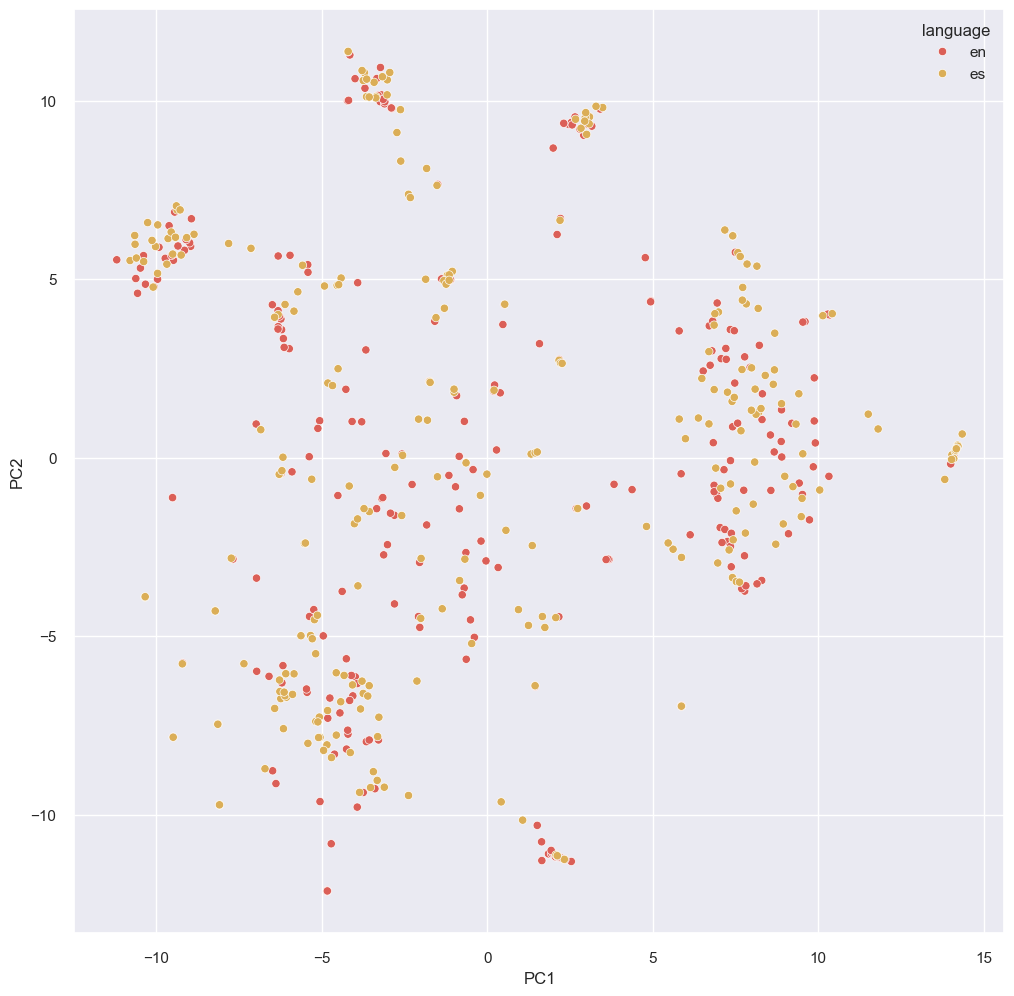

In [71]:
both_embeddings = np.concatenate((en_embeddings, es_embeddings))

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(both_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

tsne_df = pd.concat([en_df_clusters, es_df_clusters])
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

tsne_df = tsne_df.reset_index()

for idx, row in tsne_df.iterrows():
    if idx < 280:
        tsne_df.at[idx, 'language'] = 'en'
    else:
        tsne_df.at[idx, 'language'] = 'es'

sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='language', palette=sns.color_palette("hls",10), legend="full")